# Quantum Transfer Learning

First we need to load image datasets. Torchvision library is used to load the image datasets.

In [1]:
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "l"

In [2]:
n_qubits = 4
steps = 0.0004
batch_size = 4
num_epochs = 1
q_depth = 6
gamma_lr_scheduler = 0.1
q_delta = 0.01
start_time = time.time()

In [3]:
dev = qml.device("default.qubit", wires = n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
#cuda is used if available. Cpu is used instead.

In [11]:
data_transform = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]          
        ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transform[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True)
    for x in ["train", "validation"]
}

def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

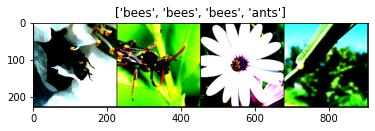

In [15]:
inputs, classes = next(iter(dataloaders["validation"]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title = [class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True)
    for x in ["train", "validation"]
}

### 1. Variational Quantum Circuit

In [16]:
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires = idx)

def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires = idx)

def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires = [i,i+1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires = [i,i+1])

In [17]:
@qml.qnode(dev, interface = "torch", diff_method = "parameter-shift")
def quantum_net(q_input_features, q_weights_flat):
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    
    H_layer(n_qubits)
    RY_layer(q_input_features)
    
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])
        
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)